In [1]:
from beta_encoder import BetaEncoder
from SFCN import SFCN, get_Bb_dims
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch

In [2]:
encoder = BetaEncoder(in_ch=1, out_ch=5, base_ch=8, final_act='none')

In [3]:
encoder = encoder.eval()
encoder = encoder.to('cuda')

In [4]:
sample_pth = 'data/ADNI/AD-BASE-prep/005_S_0814_I24734_MP-RAGE.nii.gz_prep.nii.gz'

In [5]:
nii_image = nib.load(sample_pth)
nii_image = nii_image.get_fdata().astype(np.float32)

In [6]:
from torchvision.transforms import Compose, Pad, CenterCrop, ToTensor, ToPILImage
default_transform = Compose([ToPILImage(), Pad(40), CenterCrop([224, 224])])

In [7]:
def slice_to_tensor(slice):
    # shape: (192, 224)
    p95 = np.percentile(slice, 95)
    slice = slice / (p95 + 1e-5)
    slice = np.clip(slice, a_min=0.0, a_max=1.0)
    slice = np.array(default_transform(slice))
    slice = ToTensor()(slice)
    return slice

def img_to_tensor(img):
    tensor_img = torch.empty(0)
    for slice in nii_image:
        slice = slice_to_tensor(slice)
        tensor_img = torch.cat((tensor_img, slice.unsqueeze(0)), dim=0)
    return tensor_img

In [8]:
def background_mask(img):
    # shape: (192, 224, 224)
    masks = torch.empty(0)
    for slice in img:
        # shape: (224, 224)
        mask = (torch.ones([224, 224]) * slice.ge(0.2)).bool()
        masks = torch.cat((masks, mask.unsqueeze(0)), dim=0)
    return masks

In [9]:
tensor_img = img_to_tensor(nii_image)
mask = background_mask(tensor_img)
print("Tensor_img shape:", tensor_img.shape)
print("Mask shape:", mask.shape)

Tensor_img shape: torch.Size([192, 1, 224, 224])
Mask shape: torch.Size([192, 1, 224, 224])


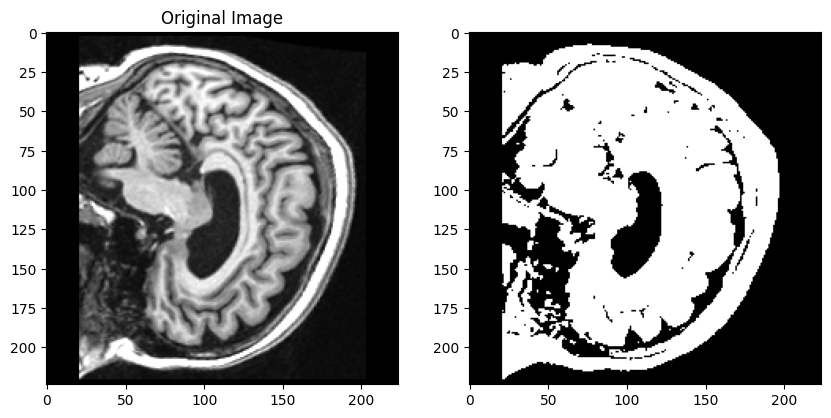

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(tensor_img[100, 0, :, :], cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(mask[100, 0, :, :], cmap='gray')

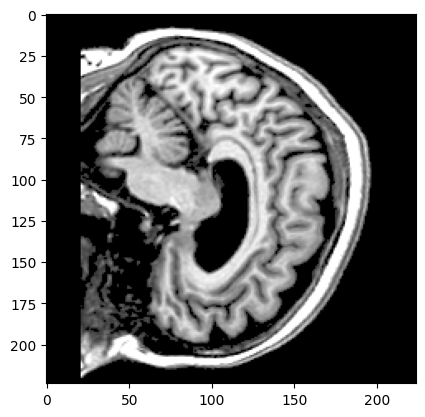

In [11]:
masked_img = tensor_img * mask
plt.imshow(masked_img[100, 0, :, :], cmap='gray')

In [12]:
res = encoder.encode(masked_img.cuda())

In [13]:
res_cpu = res.cpu().detach().numpy()

In [14]:
res_cpu = res_cpu * mask.numpy()

In [15]:
res.shape

torch.Size([192, 5, 224, 224])

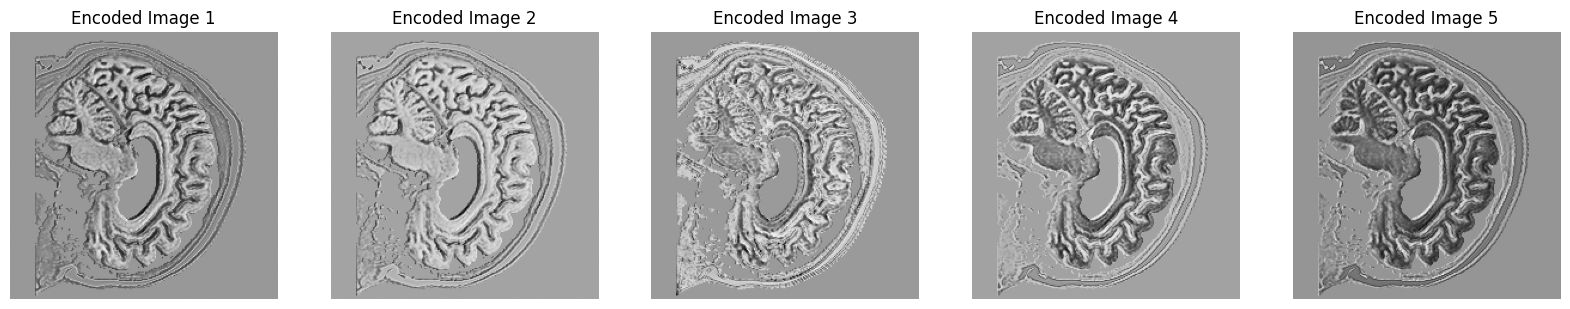

In [16]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    ax[i].imshow(res_cpu[100, i, :, :], cmap='gray')
    ax[i].set_title(f'Encoded Image {i+1}')
    ax[i].axis('off')
plt.show()

In [17]:
import torch.nn.functional as F

In [18]:
def reparameterize_logit(logit):
    beta = F.gumbel_softmax(logit, tau=1.0, dim=1, hard=True)
    return beta

In [19]:
beta = reparameterize_logit(res)

In [20]:
beta.shape

torch.Size([192, 5, 224, 224])

In [21]:
batch_size = beta.shape[0]
image_dim = beta.shape[3]
print("Batch size:", batch_size)
print("Image dimension:", image_dim)

Batch size: 192
Image dimension: 224


In [22]:
value_tensor = (torch.arange(0, 5) * 1.0).to('cuda')
value_tensor = value_tensor.view(1, 5, 1, 1).repeat(batch_size, 1, image_dim, image_dim)
beta_label_encode = beta * value_tensor.detach()

In [23]:
beta_label_encode = beta_label_encode.sum(dim=1, keepdim=True) / 5.0

In [24]:
beta_label_encode_cpu = beta_label_encode.cpu().detach().numpy()

In [25]:
masked_beta = (beta_label_encode * mask.cuda()).cpu().detach().numpy()

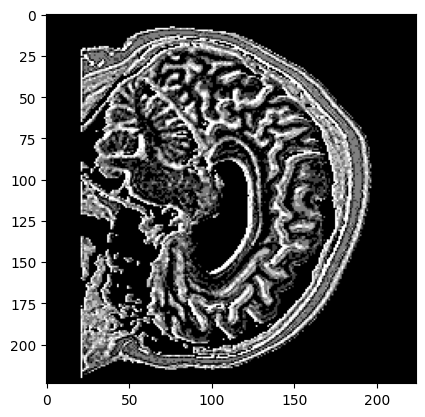

In [26]:
plt.imshow(masked_beta[100, 0, :, :], cmap='gray')

In [1]:
from dataset_adni import ADNI, ADNI_BASE_CN, ADNI_BASE_AD
import torch.nn.functional as F
from beta_encoder import BetaEncoder
from SFCN import SFCN, get_Bb_dims
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch
encoder = BetaEncoder(in_ch=1, out_ch=5, base_ch=8, final_act='none')
encoder.cuda()

BetaEncoder(
  (unet): UNet(
    (in_conv): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_convs): ModuleList(
      (0): ConvBlock2d(
        (conv): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (2): LeakyReLU(negative_slope=0.1)
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (5): LeakyReLU(negative_slope=0.1)
        )
      )
      (1): ConvBlock2d(
        (conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (2): LeakyReLU(negative_slope=0.1)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1)

In [2]:
s = ADNI_BASE_CN()
print(s[:5])

['data/ADNI/CN-BASE-prep/133_S_0488_I16437_MPRAGE.nii.gz_prep.nii.gz', 'data/ADNI/CN-BASE-prep/051_S_1123_I38263_MPRAGE_Repeat.nii.gz_prep.nii.gz', 'data/ADNI/CN-BASE-prep/131_S_1301_I49328_MP-RAGE.nii.gz_prep.nii.gz', 'data/ADNI/CN-BASE-prep/032_S_0677_I26006_MPRAGE.nii.gz_prep.nii.gz', 'data/ADNI/CN-BASE-prep/116_S_1249_I42155_MPRAGE_Repeat.nii.gz_prep.nii.gz']


In [3]:
d = ADNI()

In [4]:
def reparameterize_logit(logit):
    beta = F.gumbel_softmax(logit, tau=1.0, dim=1, hard=True)
    return beta

In [5]:
def get_beta(img, mask):
    logit = reparameterize_logit(encoder.encode(torch.unsqueeze(img, dim=1).cuda()))
    value_tensor = (torch.arange(0, 5) * 1.0).to('cuda')
    value_tensor = value_tensor.view(1, 5, 1, 1).repeat(logit.shape[0], 1, logit.shape[2], logit.shape[3])
    beta_label_encode = logit * value_tensor.detach()
    beta_label_encode = beta_label_encode.sum(dim=1, keepdim=True) / 5.0
    beta_label_encode = beta_label_encode
    return beta_label_encode

In [6]:
sample = d[0]

In [7]:
img = sample['masked_image']
mask = sample['mask']

In [8]:
beta = get_beta(img, mask)

In [9]:
beta_cpu = beta.cpu().detach().numpy()

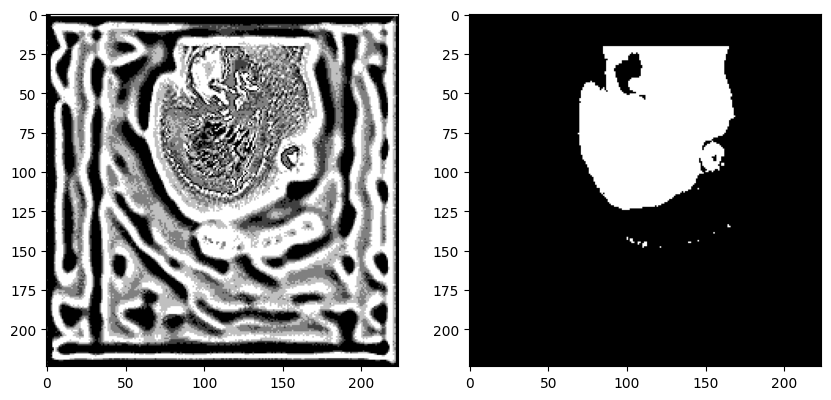

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(beta_cpu[13, 0, :, :], cmap='gray')
ax[1].imshow(mask[13, :, :], cmap='gray')

In [11]:
beta.shape

torch.Size([192, 1, 224, 224])

In [12]:
mask = mask.to("cuda:0")

In [14]:
mask = torch.unsqueeze(mask, dim=1)

In [15]:
masked_beta = beta * mask

In [16]:
masked_beta.shape

torch.Size([192, 1, 224, 224])

In [18]:
masked_beta_cpu = masked_beta.cpu().detach().numpy()

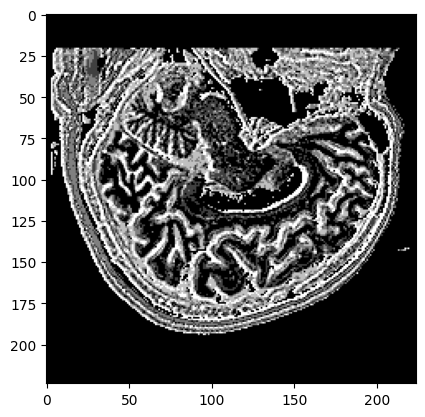

In [34]:
plt.imshow(masked_beta_cpu[100, 0, :, :], cmap='gray')